In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from diffusers import UNet2DModel, DDPMScheduler
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size =8
    eval_batch_size = 8  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-butterflies-128-3-with-withplt'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()



In [21]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")
#dataset = dataset.shuffle(seed=42).select(range(100))

Repo card metadata block was not found. Setting CardData to empty.


In [22]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

C:\Users\User\AppData\Local\Temp\ipykernel_1180\1829702657.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


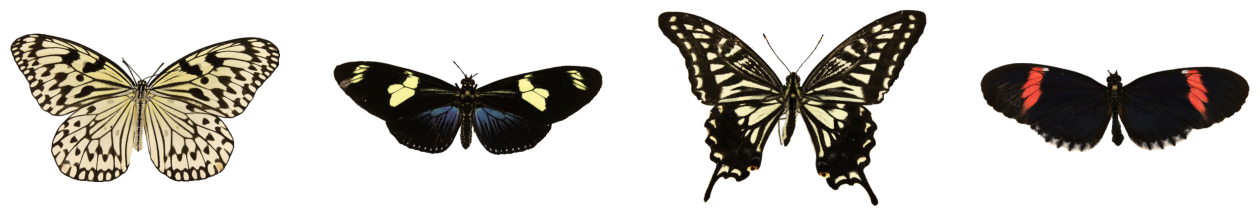

In [23]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [24]:

from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [25]:

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [26]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [27]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [28]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [29]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


In [30]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

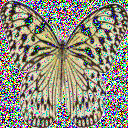

In [31]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [32]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [33]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [34]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [35]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [36]:
import torch.nn as nn

class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dip_model = DIPModel().to(device)
dip_optimizer = torch.optim.Adam(dip_model.parameters(), lr=1e-3)
num_dip_epochs = 10  # 可以调整

for epoch in range(num_dip_epochs):
    for batch in train_dataloader:
        images = batch['images'].to(device)  # 确保图像已经移动到正确的设备
        dip_optimizer.zero_grad()
        noisy_images = images + 0.1 * torch.randn_like(images)
        pred_images = dip_model(noisy_images)
        loss = F.mse_loss(pred_images, images)
        loss.backward()
        dip_optimizer.step()


In [38]:
import os
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from pytorch_fid.inception import InceptionV3
import numpy as np
from scipy.linalg import sqrtm

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def calculate_fid(real_images, fake_images, device):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx]).to(device)

    def get_activations(images):
        images = images.to(device)
        if images.size(1) == 1:
            images = images.repeat(1, 3, 1, 1)
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        pred = model(images)[0]
        pred = pred.cpu().numpy()
        return pred

    act1 = get_activations(real_images)
    act2 = get_activations(fake_images)

    act1 = act1.reshape(act1.shape[0], -1)
    act2 = act2.reshape(act2.shape[0], -1)

    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance."""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        print("fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Metrics
    psnr = PeakSignalNoiseRatio().to(accelerator.device)
    ssim = StructuralSimilarityIndexMeasure().to(accelerator.device)

    # Lists to store metrics
    loss_list = []
    psnr_list = []
    ssim_list = []
    fid_list = []

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            initial_state = dip_model(clean_images).detach()
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(initial_state, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            # Log loss
            loss_list.append(loss.item())
            
            progress_bar.update(1)
            logs = {"loss": loss.item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # Calculate metrics once per epoch
        psnr_val = psnr(noisy_images, clean_images).item()
        ssim_val = ssim(noisy_images, clean_images).item()
        fid_val = calculate_fid(clean_images, noisy_images, device=accelerator.device)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        fid_list.append(fid_val)

        epoch_logs = {"psnr": psnr_val, "ssim": ssim_val, "fid": fid_val}
        tqdm.write(f"Epoch {epoch + 1} - PSNR: {psnr_val}, SSIM: {ssim_val}, FID: {fid_val}")
        accelerator.log(epoch_logs, step=global_step)

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

    # Plotting the metrics
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 2, 1)
    plt.plot(loss_list, label='Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(psnr_list, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(ssim_list, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(fid_list, label='FID')
    plt.xlabel('Epoch')
    plt.ylabel('FID')
    plt.legend()

    plt.tight_layout()
    plt.show()




Launching training on one GPU.


c:\Users\User\anaconda3\envs\env4\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
c:\Users\User\anaconda3\envs\env4\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]c:\Users\User\anaconda3\envs\env4\lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct

Epoch 1 - PSNR: 6.548252105712891, SSIM: 0.14708438515663147, FID: 161.21286478516424


Epoch 0: 100%|██████████| 125/125 [01:01<00:00,  2.04it/s, loss=0.0703, lr=2.5e-5, step=124]

                                                                                       

Epoch 2 - PSNR: 5.51186466217041, SSIM: 0.1776752769947052, FID: 140.17308381212138


Epoch 2: 100%|██████████| 125/125 [00:56<00:00,  2.50it/s, loss=0.0566, lr=7.5e-5, step=374] 

Epoch 3 - PSNR: 7.767721652984619, SSIM: 0.25318172574043274, FID: 164.19769449977161


Epoch 2: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s, loss=0.0566, lr=7.5e-5, step=374]

                                                                                         

Epoch 4 - PSNR: 4.801992416381836, SSIM: 0.050806332379579544, FID: 137.0337665695757


Epoch 4: 100%|██████████| 125/125 [00:59<00:00,  2.46it/s, loss=0.184, lr=9.99e-5, step=624]  

Epoch 5 - PSNR: 6.7813215255737305, SSIM: 0.2718004286289215, FID: 161.36653249406226


Epoch 4: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s, loss=0.184, lr=9.99e-5, step=624]

                                                                                          

Epoch 6 - PSNR: 5.461052894592285, SSIM: 0.14085549116134644, FID: 147.13472241752027


Epoch 6: 100%|██████████| 125/125 [00:55<00:00,  2.55it/s, loss=0.0141, lr=9.9e-5, step=874]  

Epoch 7 - PSNR: 7.259988784790039, SSIM: 0.188470259308815, FID: 156.8578910608319


Epoch 6: 100%|██████████| 125/125 [00:55<00:00,  2.23it/s, loss=0.0141, lr=9.9e-5, step=874]

                                                                                          

Epoch 8 - PSNR: 5.526139736175537, SSIM: 0.12814952433109283, FID: 144.01261876828036


Epoch 8: 100%|██████████| 125/125 [00:57<00:00,  2.47it/s, loss=0.00484, lr=9.71e-5, step=1124]

Epoch 9 - PSNR: 4.876454830169678, SSIM: 0.04998555779457092, FID: 151.2471809692371


Epoch 8: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s, loss=0.00484, lr=9.71e-5, step=1124]

                                                                                            

Epoch 10 - PSNR: 4.778796195983887, SSIM: 0.041462309658527374, FID: 147.96436945554308


Epoch 10: 100%|██████████| 125/125 [00:56<00:00,  2.53it/s, loss=0.00744, lr=9.44e-5, step=1374]

Epoch 11 - PSNR: 5.00023078918457, SSIM: 0.11826412379741669, FID: 148.7696337049918


Epoch 10: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s, loss=0.00744, lr=9.44e-5, step=1374]

                                                                                             

Epoch 12 - PSNR: 4.547026634216309, SSIM: 0.029825430363416672, FID: 142.55993005840318


Epoch 12: 100%|██████████| 125/125 [00:54<00:00,  2.55it/s, loss=0.0152, lr=9.08e-5, step=1624] 

Epoch 13 - PSNR: 6.418049335479736, SSIM: 0.16919302940368652, FID: 149.8872690269975


Epoch 12: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s, loss=0.0152, lr=9.08e-5, step=1624]

                                                                                           

Epoch 14 - PSNR: 5.398741245269775, SSIM: 0.16207505762577057, FID: 146.65098663285295


Epoch 14: 100%|██████████| 125/125 [00:54<00:00,  2.51it/s, loss=0.00877, lr=8.65e-5, step=1874]

Epoch 15 - PSNR: 6.491065502166748, SSIM: 0.12335877120494843, FID: 147.21162529811767


Epoch 14: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.00877, lr=8.65e-5, step=1874]

                                                                                            

Epoch 16 - PSNR: 7.244393825531006, SSIM: 0.17432034015655518, FID: 166.928567240391


Epoch 16: 100%|██████████| 125/125 [00:54<00:00,  2.57it/s, loss=0.0138, lr=8.16e-5, step=2124] 

Epoch 17 - PSNR: 6.336367130279541, SSIM: 0.22349408268928528, FID: 162.90198597941713


Epoch 16: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s, loss=0.0138, lr=8.16e-5, step=2124]

                                                                                             

Epoch 18 - PSNR: 5.115230560302734, SSIM: 0.10372565686702728, FID: 151.10403814765402


Epoch 18: 100%|██████████| 125/125 [00:54<00:00,  2.59it/s, loss=0.00534, lr=7.6e-5, step=2374] 

Epoch 19 - PSNR: 5.146165370941162, SSIM: 0.1148124411702156, FID: 137.8366541986664


Epoch 18: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s, loss=0.00534, lr=7.6e-5, step=2374]

                                                                                            

Epoch 20 - PSNR: 5.729578971862793, SSIM: 0.09354948252439499, FID: 159.40873481659787


Epoch 20: 100%|██████████| 125/125 [00:54<00:00,  3.15it/s, loss=0.00527, lr=6.99e-5, step=2624]

Epoch 21 - PSNR: 5.00023078918457, SSIM: 0.11826412379741669, FID: 148.7696337049918


Epoch 20: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.00527, lr=6.99e-5, step=2624]

                                                                                             

Epoch 22 - PSNR: 4.547026634216309, SSIM: 0.029825430363416672, FID: 142.55993005840318


Epoch 22: 100%|██████████| 125/125 [00:54<00:00,  3.10it/s, loss=0.0134, lr=6.35e-5, step=2874] 

Epoch 23 - PSNR: 6.418049335479736, SSIM: 0.16919302940368652, FID: 149.8872690269975


Epoch 22: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s, loss=0.0134, lr=6.35e-5, step=2874]

                                                                                            

Epoch 24 - PSNR: 5.398741245269775, SSIM: 0.16207505762577057, FID: 146.65098663285295


Epoch 24: 100%|██████████| 125/125 [00:54<00:00,  3.16it/s, loss=0.00721, lr=5.68e-5, step=3124]

Epoch 25 - PSNR: 6.491065502166748, SSIM: 0.12335877120494843, FID: 147.21162529811767


Epoch 24: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s, loss=0.00721, lr=5.68e-5, step=3124]

                                                                                             

Epoch 26 - PSNR: 7.244393825531006, SSIM: 0.17432034015655518, FID: 166.928567240391


Epoch 26: 100%|██████████| 125/125 [00:54<00:00,  3.14it/s, loss=0.0117, lr=5e-5, step=3374]    

Epoch 27 - PSNR: 6.336367130279541, SSIM: 0.22349408268928528, FID: 162.90198597941713


Epoch 26: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.0117, lr=5e-5, step=3374]

                                                                                             

Epoch 28 - PSNR: 5.115230560302734, SSIM: 0.10372565686702728, FID: 151.10403814765402


Epoch 28: 100%|██████████| 125/125 [00:53<00:00,  3.08it/s, loss=0.00463, lr=4.32e-5, step=3624]

Epoch 29 - PSNR: 5.146165370941162, SSIM: 0.1148124411702156, FID: 137.8366541986664


Epoch 28: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s, loss=0.00463, lr=4.32e-5, step=3624]

                                                                                             

Epoch 30 - PSNR: 5.729578971862793, SSIM: 0.09354948252439499, FID: 159.40873481659787


Epoch 30: 100%|██████████| 125/125 [00:54<00:00,  3.10it/s, loss=0.00465, lr=3.65e-5, step=3874]

Epoch 31 - PSNR: 5.00023078918457, SSIM: 0.11826412379741669, FID: 148.7696337049918


Epoch 30: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s, loss=0.00465, lr=3.65e-5, step=3874]

                                                                                             

Epoch 32 - PSNR: 4.547026634216309, SSIM: 0.029825430363416672, FID: 142.55993005840318


Epoch 32: 100%|██████████| 125/125 [00:54<00:00,  3.13it/s, loss=0.0118, lr=3.01e-5, step=4124] 

Epoch 33 - PSNR: 6.418049335479736, SSIM: 0.16919302940368652, FID: 149.8872690269975


Epoch 32: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s, loss=0.0118, lr=3.01e-5, step=4124]

                                                                                           

Epoch 34 - PSNR: 5.398741245269775, SSIM: 0.16207505762577057, FID: 146.65098663285295


Epoch 34: 100%|██████████| 125/125 [00:54<00:00,  3.11it/s, loss=0.00639, lr=2.4e-5, step=4374]  

Epoch 35 - PSNR: 6.491065502166748, SSIM: 0.12335877120494843, FID: 147.21162529811767


Epoch 34: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s, loss=0.00639, lr=2.4e-5, step=4374]

                                                                                             

Epoch 36 - PSNR: 7.244393825531006, SSIM: 0.17432034015655518, FID: 166.928567240391


Epoch 36: 100%|██████████| 125/125 [00:54<00:00,  3.11it/s, loss=0.0103, lr=1.84e-5, step=4624] 

Epoch 37 - PSNR: 6.336367130279541, SSIM: 0.22349408268928528, FID: 162.90198597941713


Epoch 36: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.0103, lr=1.84e-5, step=4624]

                                                                                             

Epoch 38 - PSNR: 5.115230560302734, SSIM: 0.10372565686702728, FID: 151.10403814765402


Epoch 38: 100%|██████████| 125/125 [00:54<00:00,  3.12it/s, loss=0.00416, lr=1.35e-5, step=4874]

Epoch 39 - PSNR: 5.146165370941162, SSIM: 0.1148124411702156, FID: 137.8366541986664


Epoch 38: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.00416, lr=1.35e-5, step=4874]

                                                                                             

Epoch 40 - PSNR: 5.729578971862793, SSIM: 0.09354948252439499, FID: 159.40873481659787


Epoch 40: 100%|██████████| 125/125 [00:54<00:00,  3.09it/s, loss=0.00429, lr=9.15e-6, step=5124]

Epoch 41 - PSNR: 5.00023078918457, SSIM: 0.11826412379741669, FID: 148.7696337049918


Epoch 40: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.00429, lr=9.15e-6, step=5124]

                                                                                             

Epoch 42 - PSNR: 4.547026634216309, SSIM: 0.029825430363416672, FID: 142.55993005840318


Epoch 42: 100%|██████████| 125/125 [00:55<00:00,  3.10it/s, loss=0.0105, lr=5.61e-6, step=5374] 

Epoch 43 - PSNR: 6.418049335479736, SSIM: 0.16919302940368652, FID: 149.8872690269975


Epoch 42: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s, loss=0.0105, lr=5.61e-6, step=5374]

                                                                                            

Epoch 44 - PSNR: 5.398741245269775, SSIM: 0.16207505762577057, FID: 146.65098663285295


Epoch 44: 100%|██████████| 125/125 [00:54<00:00,  3.13it/s, loss=0.00578, lr=2.89e-6, step=5624] 

Epoch 45 - PSNR: 6.491065502166748, SSIM: 0.12335877120494843, FID: 147.21162529811767


Epoch 44: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s, loss=0.00578, lr=2.89e-6, step=5624]

                                                                                             

Epoch 46 - PSNR: 7.244393825531006, SSIM: 0.17432034015655518, FID: 166.928567240391


Epoch 46: 100%|██████████| 125/125 [00:53<00:00,  3.14it/s, loss=0.0095, lr=1.05e-6, step=5874] 

Epoch 47 - PSNR: 6.336367130279541, SSIM: 0.22349408268928528, FID: 162.90198597941713


Epoch 46: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s, loss=0.0095, lr=1.05e-6, step=5874]

                                                                                             

Epoch 48 - PSNR: 5.115230560302734, SSIM: 0.10372565686702728, FID: 151.10403814765402


Epoch 48: 100%|██████████| 125/125 [00:53<00:00,  3.07it/s, loss=0.00399, lr=1.17e-7, step=6124]

Epoch 49 - PSNR: 5.146165370941162, SSIM: 0.1148124411702156, FID: 137.8366541986664


Epoch 48: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s, loss=0.00399, lr=1.17e-7, step=6124]

                                                                                      

Epoch 50 - PSNR: 5.729578971862793, SSIM: 0.09354948252439499, FID: 159.40873481659787


100%|██████████| 1000/1000 [01:09<00:00, 14.38it/s]


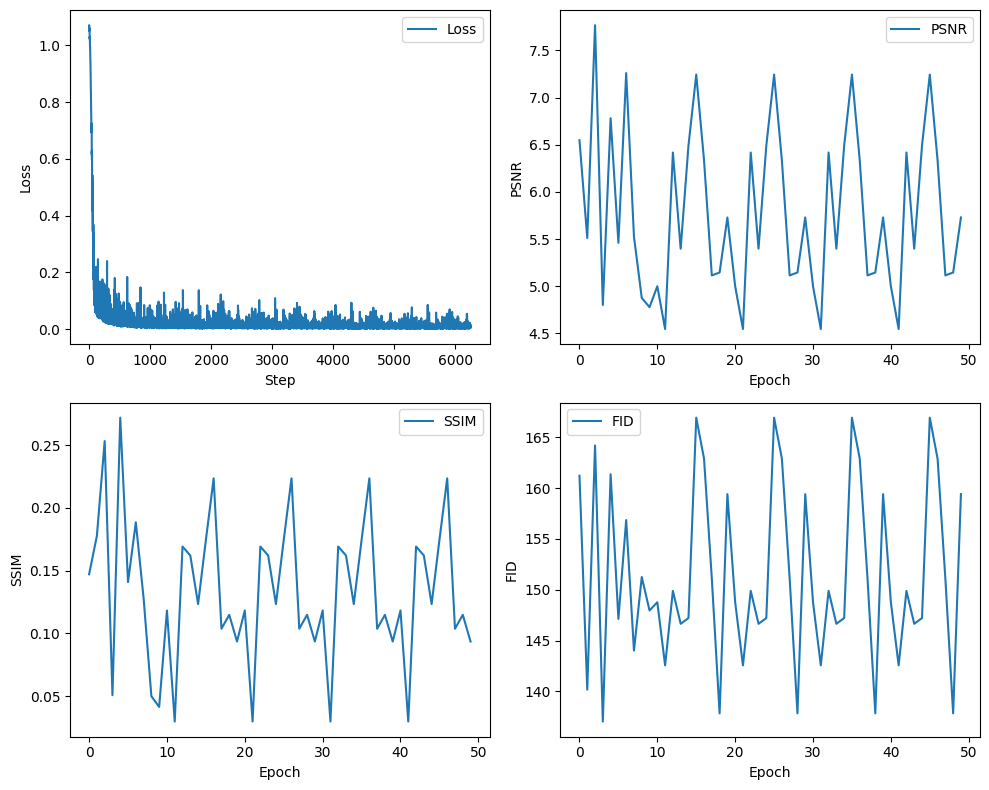

Epoch 49: 100%|██████████| 125/125 [02:06<00:00,  1.01s/it, loss=0.0052, lr=0, step=6249]


In [39]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

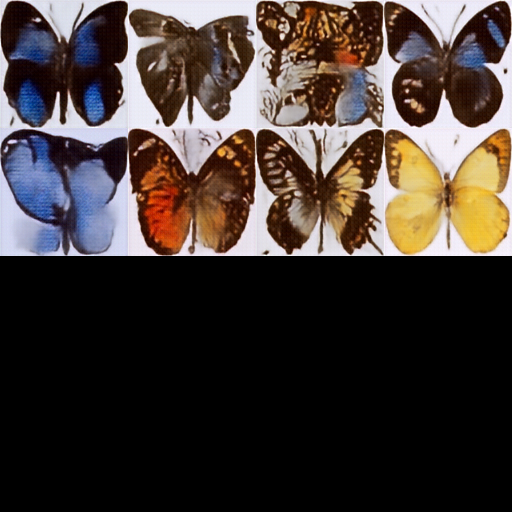

In [40]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])